# GradCAM - Gradient Class Activation Map

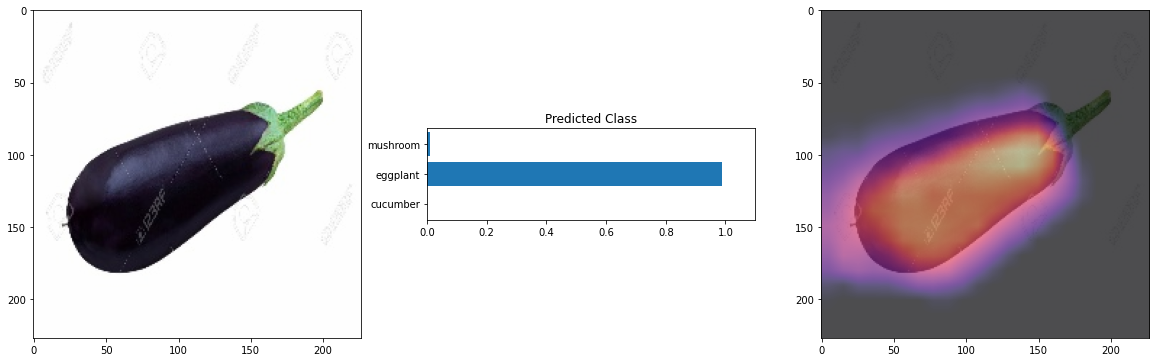

In [28]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

fatal: destination path 'GradCAM-Dataset' already exists and is not an empty directory.


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-os9ke2rb
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-os9ke2rb
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable


# Imports

In [29]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [31]:
csv_file = './GradCAM-Dataset/train.csv'
data_dir = './GradCAM-Dataset/'

device = 'cuda'
batch_size = 16
lr = 0.001
epochs = 20

In [32]:
data = pd.read_csv(csv_file)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [33]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [34]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_augs = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

# Load Image Dataset

In [39]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = data_dir)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = data_dir)


AttributeError: module 'utils' has no attribute 'ImageDataset'

Text(0.5, 1.0, 'mushroom')

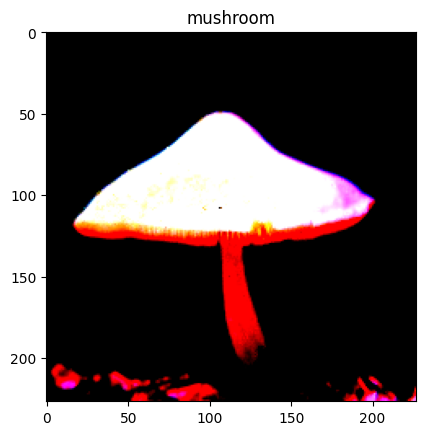

In [ ]:
image, label = validset[5] # (c, h, w) -> (h, w, c) while plotting

class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label])

In [ ]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images, labels in trainloader:
  break
print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

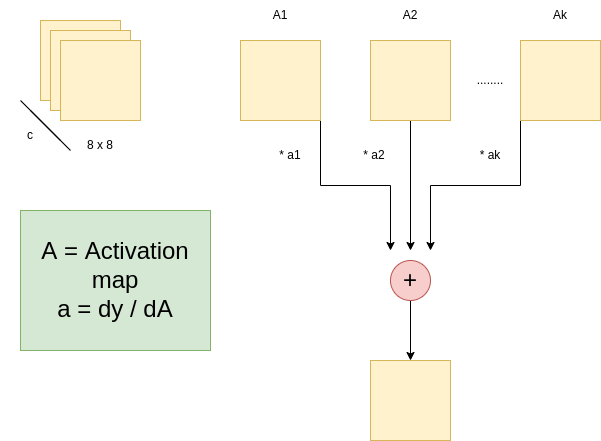

In [ ]:
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
      )

    self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(6400, 2048),
      nn.ReLU(),
      nn.Linear(2048, 3)
    )
    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images) # activation maps

    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)
    return x

  def get_activation_gradients(self): # a1, a2, a3, ... ak
    return self.gradient

  def get_activation(self, x): # A1, A2, A3, ... AK
    return self.feature_extractor(x)


# we use the two above functions to find a1*A1 + a2*A2 + ... aK*AK


In [ ]:
model = ImageModel()
model.to(device)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [ ]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()

    total_loss += loss.item()
  return total_loss/len(dataloader)

# Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")
  print(f"Epoch = {i+1}, train los = {train_loss}")

100%|██████████| 3/3 [00:00<00:00, 18.53it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 1, train los = 1.1164997100830079


100%|██████████| 3/3 [00:00<00:00, 21.28it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 2, train los = 0.6673656374216079


100%|██████████| 3/3 [00:00<00:00, 21.71it/s]


Epoch = 3, train los = 0.3527529502287507


100%|██████████| 3/3 [00:00<00:00, 21.79it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 4, train los = 0.667549604922533


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 5, train los = 0.5304715454578399


100%|██████████| 3/3 [00:00<00:00, 13.75it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 6, train los = 0.24287139549851416


100%|██████████| 3/3 [00:00<00:00, 14.67it/s]


Epoch = 7, train los = 0.14310095831751823


100%|██████████| 3/3 [00:00<00:00, 14.04it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 8, train los = 0.16514642124529927


100%|██████████| 3/3 [00:00<00:00, 15.41it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 9, train los = 0.11406027395278215


100%|██████████| 3/3 [00:00<00:00, 19.03it/s]


Epoch = 10, train los = 0.38349562166258694


100%|██████████| 3/3 [00:00<00:00, 18.80it/s]


Epoch = 11, train los = 0.20338853830471634


100%|██████████| 3/3 [00:00<00:00, 21.02it/s]


Epoch = 12, train los = 0.24315518531948327


100%|██████████| 3/3 [00:00<00:00, 22.76it/s]


Epoch = 13, train los = 0.11641809418797493


100%|██████████| 3/3 [00:00<00:00, 21.73it/s]


Epoch = 14, train los = 0.07139041488226212


100%|██████████| 3/3 [00:00<00:00, 22.21it/s]


Epoch = 15, train los = 0.04822439115960151


100%|██████████| 3/3 [00:00<00:00, 23.03it/s]


Epoch = 16, train los = 0.05278730652134982


100%|██████████| 3/3 [00:00<00:00, 22.94it/s]


Epoch = 17, train los = 0.07366394205018878


100%|██████████| 3/3 [00:00<00:00, 22.22it/s]


Epoch = 18, train los = 0.019520098865177714


100%|██████████| 3/3 [00:00<00:00, 21.57it/s]


SAVED_WEIGHTS_SUCCESS
Epoch = 19, train los = 0.040498219733126464


100%|██████████| 3/3 [00:00<00:00, 22.67it/s]

Epoch = 20, train los = 0.032707677618600425


# Get GradCAM

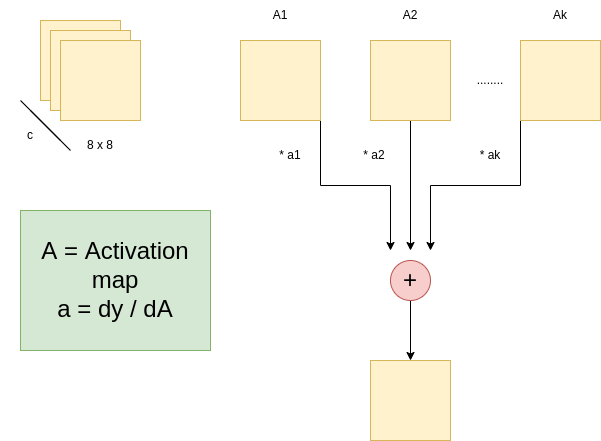

In [ ]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) # a1, a2, ..., ak
  activations = model.get_activation(image).detach() # A1, A2, ..., AK

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap


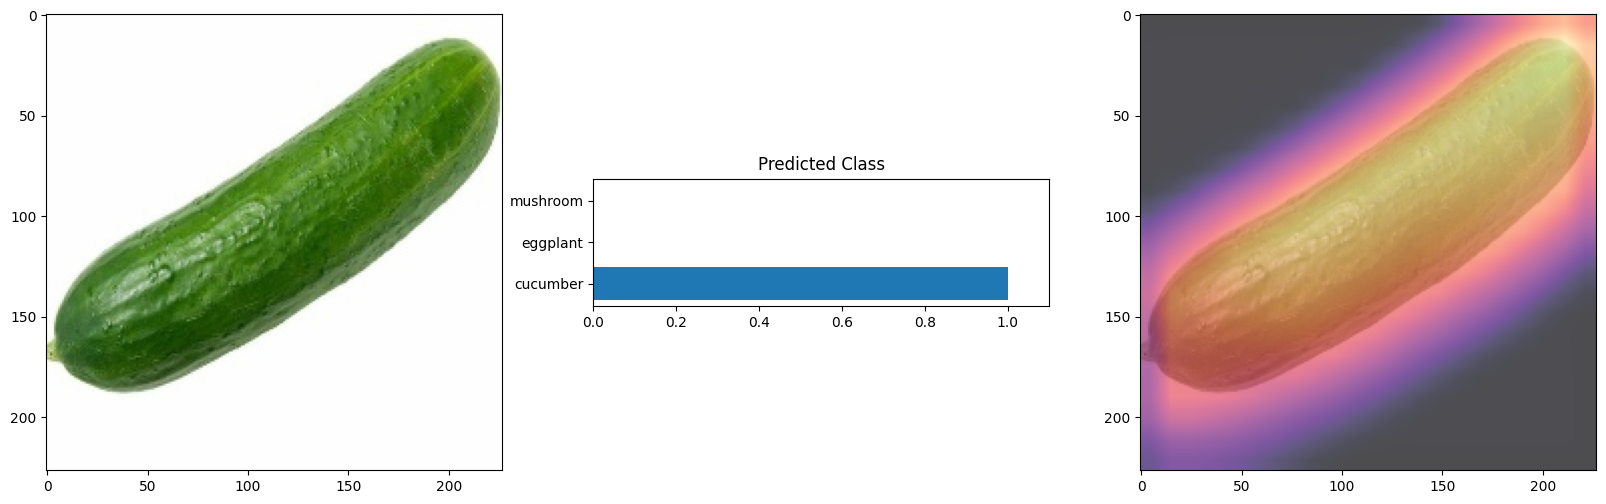

In [ ]:
image, label = validset[11]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
image = image.unsqueeze(0).to(device)
pred = model(image)

# cucumber = 0, # eggplant = 1, # mushroom = 2
heatmap = get_gradcam(model, image, pred[0][1], size=227)
utils.plot_heatmap(denorm_image, pred, heatmap)